1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

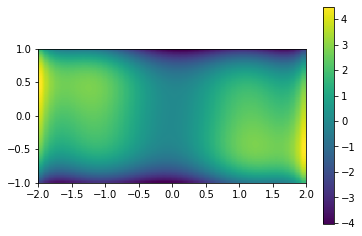

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def six_hump(x):
    return ((4-2.1*x[0]**2+x[0]**4/3)*x[0]**2+x[0]*x[1]+(-4*x[1]**2)*x[1]**2)
x=np.linspace(-2,2)
y=np.linspace(-1,1)
xs,ys=np.meshgrid(x,y)
plt.figure()
plt.imshow(six_hump([xs,ys]),extent=[-2,2,-1,1])
plt.colorbar()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

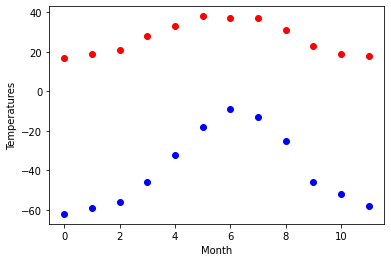

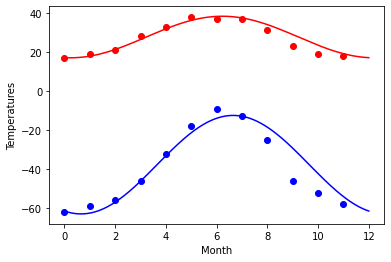

Until half of months, the fit is working. But after that it is not.


In [21]:
from scipy import optimize
maxv = np.array([17,19,21,28,33,38,37,37,31,23,19,18])
minv = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(12)
plt.plot(months,maxv,'ro')
plt.plot(months,minv,'bo')
plt.xlabel('Month')
plt.ylabel('Temperatures')
def temps(times,avg,ampl,offset):
    return (avg+ampl*np.cos((times+offset)*2*np.pi/times.max()))
maxr,covmax=optimize.curve_fit(temps,months,maxv,[20,10,0])
minr,covmin=optimize.curve_fit(temps,months,minv,[-40,20,0])
d=np.linspace(0,12,num=365)
plt.figure()
plt.plot(months,maxv,'ro')
plt.plot(d,temps(d,*maxr),'r-')
plt.plot(months,minv,'bo')
plt.plot(d,temps(d,*minr),'b-')
plt.xlabel('Month')
plt.ylabel('Temperatures')
plt.show()
print("Until half of months, the fit is working. But after that it is not.")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [35]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
import pickle
filename='residuals_261.pkl'
infile = open(filename, 'rb')
new_dict = pickle.load(infile)
infile.close()
r=new_dict['residual']
r=np.array(r)
print(r)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

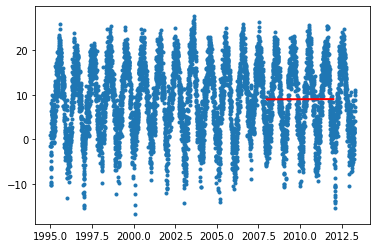

In [48]:
from scipy.optimize import curve_fit
date, temperature=np.loadtxt('munich_temperatures_average_with_bad_data.txt',unpack=True)
keep=np.abs(temperature)<90
date=date[keep]
temperature=temperature[keep]
def f(a,b,c,t):
    return a*np.cos(2*np.pi*t+b)+c
popt,pcov=curve_fit(f,date,temperature)
plt.plot(date,temperature,'.')
xfine=np.linspace(2008,2012,100)
plt.plot(xfine,f(xfine,*popt),color='red',lw=2)
